In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


In [2]:
# testing data : 10,000 signal samples and 10,000 bkg samples
traindata_sig = np.load('data/jetImages_signal.npz')
traindata_bkg = np.load('data/jetImages_bkg.npz')
testdata_sig = np.load('data/jetImages_signal_test.npz')
testdata_bkg = np.load('data/jetImages_bkg_test.npz')
trainlabels = np.concatenate((traindata_sig['labels'], traindata_bkg['labels']),axis=0)
testlabels = np.concatenate((testdata_sig['labels'], testdata_bkg['labels']),axis=0)
trainradii = np.concatenate((traindata_sig['radiilab'], traindata_bkg['radiilab']), axis = 0)
traintheta = np.concatenate((traindata_sig['thetalab'], traindata_bkg['thetalab']), axis = 0)
testradii = np.concatenate((testdata_sig['radiilab'], testdata_bkg['radiilab']), axis = 0)
test_theta = np.concatenate((testdata_sig['thetalab'], testdata_bkg['thetalab']), axis = 0)
trainz = np.concatenate((traindata_sig['zlab'], traindata_bkg['zlab']), axis = 0)
testz = np.concatenate((testdata_sig['zlab'], testdata_bkg['zlab']), axis = 0)
n_train = len(trainlabels)
n_test = len(testlabels)
print(testlabels)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [3]:
def build_model():
    input1 = layers.Input(shape=(1,), name = 'z_input')
    input2 = layers.Input(shape=(2,), name = 'radii_input')
    input3 = layers.Input(shape=(1,), name = 'theta_input')
    x = layers.concatenate(inputs = [input1, input2, input3],axis=-1, name = 'concat')
    x = layers.Dense(64, activation=tf.nn.relu, name = 'relu1')(x)
    x = layers.Dense(64, activation=tf.nn.relu, name = 'relu2')(x)
    output = layers.Dense(1, activation="sigmoid", name = 'sigmoid')(x)
    model = models.Model(inputs=[input1, input2, input3], outputs=output)
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_crossentropy', 'accuracy'])
    return model

In [4]:
MLP = build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
example_labels = trainlabels[:10]
example_radii = trainradii[:10]
example_theta = traintheta[:10]
example_z = trainz[:10]
example_result = MLP.predict(x = [example_theta, example_radii, example_z])
results = MLP.evaluate(x = [example_theta, example_radii, example_z], y = example_labels)
print(example_result)
print(results)

10/10 [==============================] - 0s 3ms/step
[[0.5214882 ]
 [0.5269304 ]
 [0.5147805 ]
 [0.51708007]
 [0.5185894 ]
 [0.52441317]
 [0.5211524 ]
 [0.5239286 ]
 [0.51602817]
 [0.52162385]]
[0.6527960896492004, 0.6527960896492004, 1.0]


In [6]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
    
checkpoint_path = "model/MLP.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 20
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = MLP.fit(
  [traintheta, trainradii, trainz], trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.00296, saving model to model/MLP.h5

Epoch 00002: val_loss improved from 0.00296 to 0.00044, saving model to model/MLP.h5

Epoch 00003: val_loss improved from 0.00044 to 0.00007, saving model to model/MLP.h5

Epoch 00004: val_loss improved from 0.00007 to 0.00003, saving model to model/MLP.h5

Epoch 00005: val_loss improved from 0.00003 to 0.00001, saving model to model/MLP.h5

Epoch 00006: val_loss improved from 0.00001 to 0.00001, saving model to model/MLP.h5

Epoch 00007: val_loss improved from 0.00001 to 0.00001, saving model to model/MLP.h5

Epoch 00008: val_loss improved from 0.00001 to 0.00000, saving model to model/MLP.h5

Epoch 00009: val_loss improved from 0.00000 to 0.00000, saving model to model/MLP.h5

Epoch 00010: val_loss improved from 0.00000 to 0.00000, saving model to model/MLP.h5

Epoch 00011: val_loss improved from 0.00000 to 0.00000, saving model to model/MLP.h5

Epoch 000

In [7]:
!ls model
best_model = keras.models.load_model('model/MLP.h5')
best_model.summary()
results = best_model.evaluate([test_theta, testradii, testz], testlabels)
print(results)

4MLP.h5			MLP.h5				  RNN_5GRU.h5
CNN_cat_multi_input.h5	RNN_1dense_4GRU.h5		  RNN.h5
CNN_class_leakyrelu.h5	RNN_2x2048_2x512_1batchrenorm.h5  RNN_jetqandml.h5
CNN_sparce_cat.h5	RNN_4GRU_gradclip.h5
CNN_test.h5		RNN_4GRU.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
radii_input (InputLayer)        (None, 2)            0                                            
__________________________________________________________________________________________________
theta_input (InputLayer)        (None, 1)            0                                            
___________________________________________________________________________________

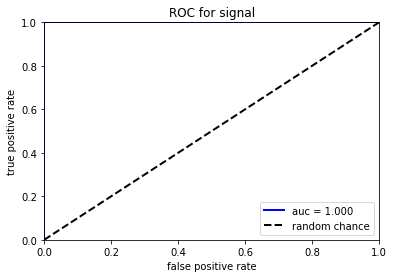

In [8]:
# Plot ROC
predict = best_model.predict([test_theta, testradii, testz])
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(testlabels, predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC for signal')
plt.legend(loc="lower right")
plt.show()
# fpr, tpr, thresholds = roc_curve(testlabels[1], predict[:,1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
# plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
# plt.xlim([0, 1.0])
# plt.ylim([0, 1.0])
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.title('ROC for signal')
# plt.legend(loc="lower right")
# plt.show()

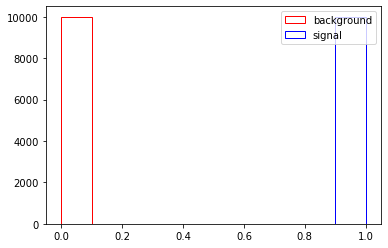

In [9]:
plt.hist([predict[:int(len(predict)/2), 0].flatten(), predict[int(len(predict)/2):, 0].flatten()] ,
         color = ['blue', 'red'], histtype = 'step', label = ['signal', 'background'])
plt.legend()
plt.show()

In [10]:
import innvestigate
import innvestigate.utils as iutils

In [11]:
# Create model without trailing softmax
# model_wo_softmax = iutils.keras.graph.model_wo_softmax(best_model)
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)
# Applying the analyzer
display = [traintheta[1], trainradii[1].reshape(1,2), trainz[1]] #the reshape is this way is because the input is expected to be 4 dimensions
analysis = lrp_analyzer.analyze(display)
print(analysis)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
[array([[0.44167516]], dtype=float32), array([[0.308116  , 0.23575094]], dtype=float32), array([[-0.9217951]], dtype=float32)]


In [12]:
toc = time.time()
def display(i):
    return [traintheta[i], trainradii[i].reshape(1,2), trainz[i]]
analysis = [lrp_analyzer.analyze( display(i) )for i in range(n_train)]

tic = time.time()
#usually takes ~100 seconds
print('\n time = \n', tic-toc)


 time = 
 10.175228595733643


In [13]:
print(analysis[0])
print( "Relevance of theta:", analysis[0][0][0][0])
print("Relevance of radius 1:", analysis[0][1][0][0])
print("Relevance of radius 2:", analysis[0][1][0][1])
print("Relevance of z:",  analysis[0][2][0][0])
total_rel = np.ndarray(shape=(20000,))
for i in range(len(predict)):
    total_rel[i] = np.sum(analysis[i][0]) + np.sum(analysis[i][1]) + np.sum(analysis[i][2])
zeros = 0
for i in range(len(predict)):
    if total_rel[i] == 0.0:
        zeros+=1
print(total_rel)
print(zeros)

[array([[0.5111576]], dtype=float32), array([[0.3080892 , 0.26497272]], dtype=float32), array([[-1.0815064]], dtype=float32)]
Relevance of theta: 0.5111576
Relevance of radius 1: 0.3080892
Relevance of radius 2: 0.26497272
Relevance of z: -1.0815064
[ 2.71308422e-03  6.37469292e-02 -2.17226386e-01 ...  2.88818214e-08
  2.22689334e-09  7.78517251e-09]
0


In [14]:
theta_analysis = np.ndarray(shape=(20000,))
z_analysis = np.ndarray(shape=(20000,))
radii1_analysis = np.ndarray(shape=(20000,))
radii2_analysis = np.ndarray(shape=(20000,))

for i in range(len(analysis)):
    theta_analysis[i] = analysis[i][0][0][0]
    z_analysis[i] = analysis[i][2][0][0]
    radii1_analysis[i] = analysis[i][1][0][0]
    radii2_analysis[i] = analysis[i][1][0][1]

In [15]:
toc = time.time()
        
sig_anal_num = 0   
sig_inef_num = 0
bkg_anal_num = 0
bkg_inef_num = 0
sig_z_rel = np.empty(1,)
bkg_z_rel = np.empty(1,)
sig_theta_rel = np.empty(1,)
bkg_theta_rel = np.empty(1,)
sig_zlab = np.empty(1,)
sig_thetalab = np.empty(1,)
bkg_zlab = np.empty(1,)
bkg_thetalab = np.empty(1,)
sig_rad1 = np.empty(1,)
sig_rad2 = np.empty(1,)
bkg_rad1 = np.empty(1,)
bkg_rad2 = np.empty(1,)


for i in range(n_train):
    if predict[i,0] > 0.50: #change to >
        sig_zlab = np.append(sig_zlab, trainz[i])
        sig_thetalab = np.append(sig_thetalab, traintheta[i])
        sig_z_rel = np.append(sig_z_rel, z_analysis[i])
        sig_theta_rel = np.append(sig_theta_rel, theta_analysis[i])
    if predict[i,0] < 0.50:
        bkg_zlab = np.append(bkg_zlab, trainz[i])
        bkg_thetalab = np.append(bkg_thetalab, traintheta[i])
        bkg_z_rel = np.append(bkg_z_rel, z_analysis[i])
        bkg_theta_rel = np.append(bkg_theta_rel, theta_analysis[i])
        #add storing of radii
#     elif i >= int(len(predict)/2) and predict[i] > 0.50:
#         bkg_inefficiency += analysis[i][0]
#         bkg_inef_num += 1
#         bkg_ineff_zlab = np.append(bkg_ineff_zlab, trainz[i])
#         bkg_ineff_thetalab = np.append(bkg_ineff_thetalab, traintheta[i])
        
#normalizing relevance scores

tic = time.time()
print('signal inefficiency = ', sig_inef_num, '\nbackground inefficiency = ', bkg_inef_num)
print('\ntime =\n', tic-toc)
print('signal efficiency = ', sig_anal_num, '\nbackground efficiency = ', bkg_anal_num)

signal inefficiency =  0 
background inefficiency =  0

time =
 1.198061227798462
signal efficiency =  0 
background efficiency =  0


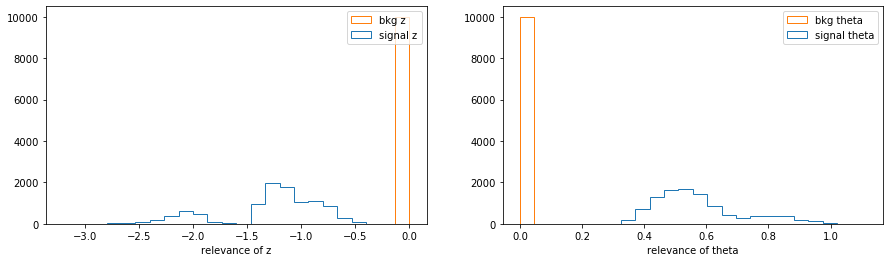

In [16]:
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.hist([z_analysis[0:int(len(predict)/2)], z_analysis[int(len(predict)/2):-1]], bins = 24, histtype = 'step',
         label = ['signal z','bkg z'])
plt.xlabel('relevance of z')
plt.legend()
plt.subplot(122)
plt.hist([theta_analysis[0:int(len(predict)/2)], theta_analysis[int(len(predict)/2):-1]], bins = 24,
         histtype = 'step', label = ['signal theta','bkg theta'])
plt.xlabel('relevance of theta')
plt.legend()
plt.show()

In [17]:
n = 20
z_array = np.zeros((n,n))
theta_array = np.zeros((n,n))
radii_array = np.zeros((n,n))
bin_dim_x = 1.2/n
bin_dim_y = 0.4/n
rad_bin = 0.6/n
trainz = trainz.flatten()
traintheta = traintheta.flatten()
for i in range(len(trainz)):
    index_x = int(trainz[i]/bin_dim_x)
    index_y = int(traintheta[i]/bin_dim_y)
    z_array[index_y, index_x] = z_analysis[i]
for i in range(len(traintheta)):
    index_x = int(trainz[i]/bin_dim_x)
    index_y = int(traintheta[i]/bin_dim_y)
    theta_array[index_y, index_x] = theta_analysis[i]
for i in range(len(trainradii)):
    index_x = int(trainz[i]/bin_dim_x)#int(trainradii[i][0]/rad_bin)
    index_y = int(traintheta[i]/bin_dim_y)#int(trainradii[i][1]/rad_bin)
    radii_array[index_y, index_x] = radii1_analysis[i] + radii2_analysis[i]

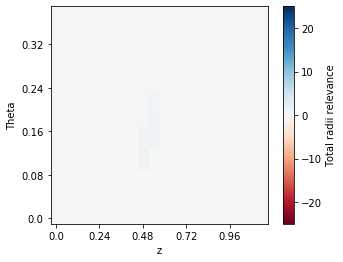

In [18]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.imshow(radii_array, origin = 'low', cmap = "RdBu")
x_ticks = np.arange(0,n,4)*bin_dim_x
y_ticks = np.arange(0,n,4)*bin_dim_y
plt.xticks(np.arange(0,n,4), np.round(x_ticks,3))
plt.yticks(np.arange(0,n,4), np.round(y_ticks,3))
plt.ylabel("Theta")
plt.xlabel("z")
plt.clim(-25,25)
cbar = plt.colorbar()
cbar.set_label('Total radii relevance')

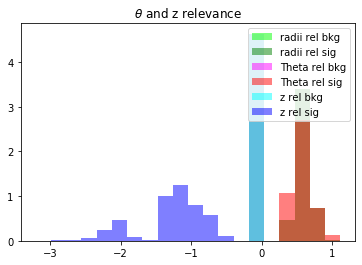

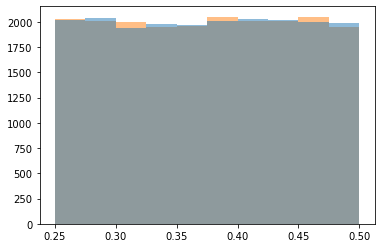

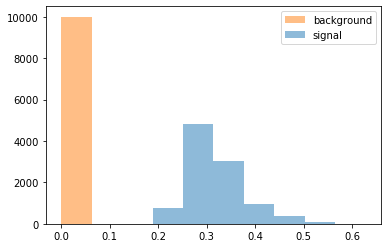

In [19]:
plt.hist([z_analysis[:int(len(predict)/2)], z_analysis[int(len(predict)/2):], theta_analysis[:int(len(predict)/2)],
          theta_analysis[int(len(predict)/2):], radii1_analysis[:int(len(predict)/2)]+radii2_analysis[:int(len(predict)/2)], radii1_analysis[int(len(predict)/2):]+radii2_analysis[int(len(predict)/2):]],bins = 20, color = ['blue', 'cyan', 'red', 'magenta', 'green', 'lime'],density=True,
         histtype='stepfilled', alpha = 0.5,
         label = ['z rel sig', 'z rel bkg', 'Theta rel sig', 'Theta rel bkg', 'radii rel sig', 'radii rel bkg'])
plt.legend()
plt.title(r'$\theta$ and z relevance')
plt.show()
plt.hist([trainradii[:, 0], trainradii[:, 1]], histtype = 'stepfilled',alpha = 0.5)
plt.show()
plt.hist([radii1_analysis[:int(len(predict)/2)], radii1_analysis[int(len(predict)/2):]], histtype = 'stepfilled',alpha = 0.5, label = ['signal', 'background'])
#LRP appears to falsely be giving relelvance to the radii, but it is a very low values
plt.legend()


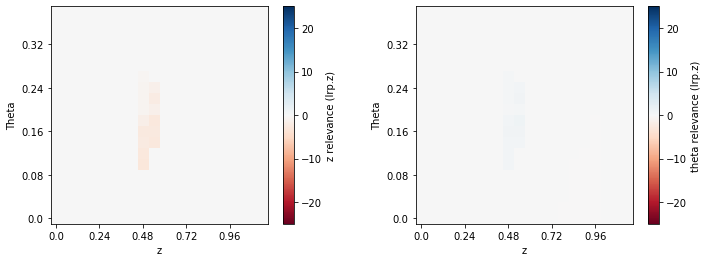

In [20]:
#makes it so that I can use Latex in the labels
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.imshow(z_array, origin = 'low', cmap ="RdBu")
x_ticks = np.arange(0,n,4)*bin_dim_x
y_ticks = np.arange(0,n,4)*bin_dim_y
plt.xticks(np.arange(0,n,4), np.round(x_ticks, 2))
plt.yticks(np.arange(0,n,4), np.round(y_ticks,2))
plt.ylabel("Theta")
plt.xlabel("z")
plt.clim(-25,25)
cbar = plt.colorbar()
cbar.set_label('z relevance (lrp.z)')
plt.subplot(1,2,2)
plt.imshow(theta_array, origin = 'low', cmap ="RdBu")
x_ticks = np.arange(0,n,4)*bin_dim_x
y_ticks = np.arange(0,n,4)*bin_dim_y
plt.xticks(np.arange(0,n,4), np.round(x_ticks,3))
plt.yticks(np.arange(0,n,4), np.round(y_ticks,3))
plt.ylabel("Theta")
plt.xlabel("z")
plt.clim(-25,25)
cbar = plt.colorbar()
cbar.set_label('theta relevance (lrp.z)')
plt.show()


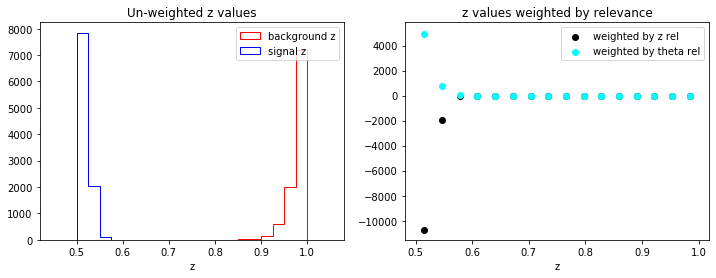

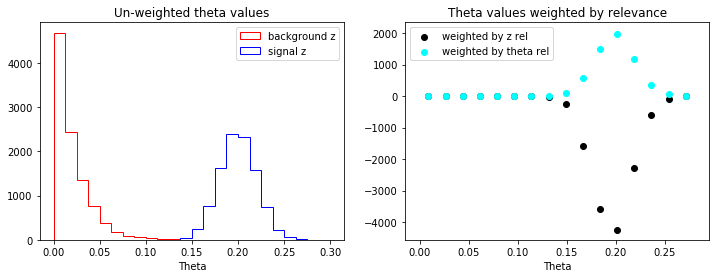

In [21]:
w_z_z, edges = np.histogram(trainz, weights = z_analysis, bins = 16)
w_z_theta, edges = np.histogram(trainz, weights = theta_analysis, bins = 16)
half_bin = (edges[1]-edges[0])/2
x = edges[0:-1]+half_bin
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist([sig_zlab[:], bkg_zlab[:]], bins = 24, range = [0.45,1.05],
         color = ['b', 'r'], histtype = 'step', label = ['signal z', 'background z'])
plt.legend()
plt.xlabel("z")
plt.title('Un-weighted z values')
plt.subplot(1,2,2)
plt.scatter(x, w_z_z, c = '0', label = 'weighted by z rel')
plt.scatter(x, w_z_theta, c = 'cyan', label = 'weighted by theta rel')
plt.xlabel("z")
plt.title("z values weighted by relevance")
plt.legend()
plt.show()

w_theta_z, edges = np.histogram(traintheta, weights = z_analysis, bins = 16)
w_theta_theta, edges = np.histogram(traintheta, weights = theta_analysis, bins = 16)
half_bin = (edges[1]-edges[0])/2
x = edges[0:-1]+half_bin
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist([sig_thetalab[:], bkg_thetalab[:]], bins = 24, range = [0.0, 0.3],
         color = ['b', 'r'], histtype = 'step', label = ['signal z', 'background z'])
plt.legend()
plt.title("Un-weighted theta values")
plt.xlabel("Theta")
plt.subplot(1,2,2)
plt.scatter(x, w_theta_z, c = '0', label = 'weighted by z rel')
plt.scatter(x, w_theta_theta, c = 'cyan', label = 'weighted by theta rel')
plt.title("Theta values weighted by relevance")
plt.xlabel('Theta')
plt.legend()
plt.show()

#ADD RADII RELEVANCE